In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from toolkit.opto import defineOptoPopulationTTest
from myphdlib.interface.nope import NOPESession
import numpy as np
from toolkit.opto import defineOptoPopulation
from toolkit.process import AnalysisObject
from myphdlib.interface.factory import SessionFactory
import os
import felsen_analysis.toolkit.saccades as fs
import felsen_analysis.toolkit.opto as op
import felsen_analysis.toolkit.populations as pop
import felsen_analysis.toolkit.plots as pl

In [3]:
h5file = '/media/jbhunt/EPHYS-01/7-24-25/squarewave/output.hdf'
basePath = '/media/jbhunt/EPHYS-01/2025-07-31_11-36-27'
clusterFile = '/media/jbhunt/EPHYS-01/7-24-25/squarewave/ephys/sorting/manual/spike_clusters.npy'
session2 = NOPESession('/media/jbhunt/EPHYS-01/7-24-25/squarewave')
matrix = session2.load('labjack/matrix')
opto = matrix[:, 14]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
#clusterList, pList = defineOptoPopulationTTest(h5file, clusterFile, optoTimes)

In [21]:
op.removeArtifacts(h5file, basePath, 'rampupdown', 'zeros', optoTimes)

write_binary_recording:   0%|          | 0/30 [00:00<?, ?it/s]

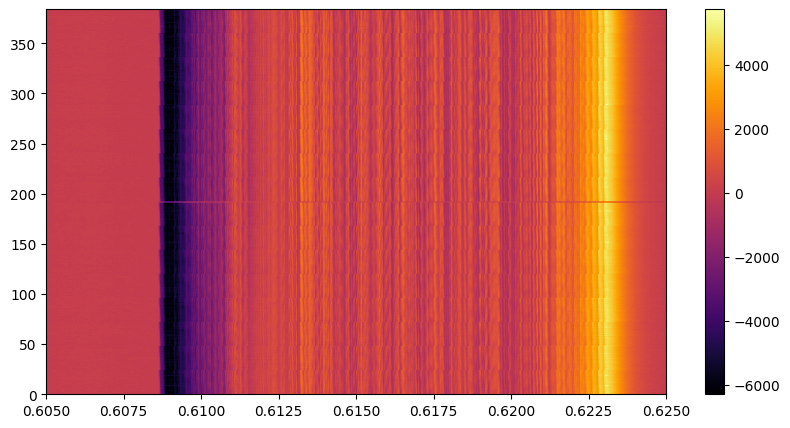

In [22]:
t2plot = [0.605, 0.625]
folderPath = '/media/jbhunt/EPHYS-01/2025-07-31_11-36-27/Record Node 101'
datPath = '/media/jbhunt/EPHYS-01/2025-07-31_11-36-27/rampupdownzerosartifact.dat'
fig, ax = op.plotRawNeuropixelsData(t2plot, folderPath, datPath, vmin=None, vmax=None)

In [4]:
clusterList, pList = op.defineOptoPopulationTTest(h5file, clusterFile, optoTimes)
optoUnitsT = list()
for i, p in enumerate(pList):
    if p < 0.01:
        optoUnitsT.append(clusterList[i])
optoUnitsManual = [99, 146, 150, 173, 181, 222, 290, 382]
optoUnitsZeta = defineOptoPopulation(h5file, clusterFile)

Text(0, 0.5, 'FR (spikes/sec)')

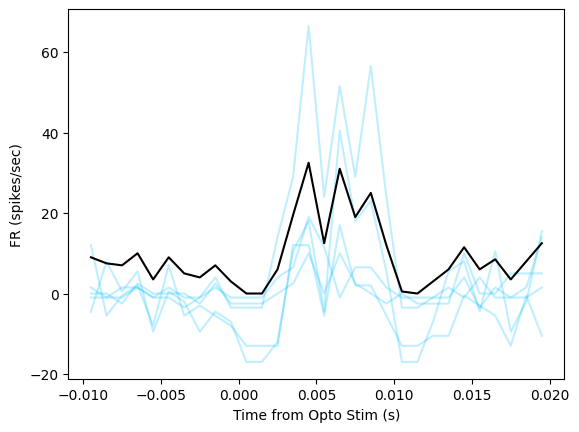

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
frList = list()
session = AnalysisObject(h5file)
population = session._population()
for unit in population:
    if unit.cluster in optoUnitsManual:
        spikeTimes = unit.timestamps
        t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.001)
        baseline = np.mean(fr[0:5])
        corrected = fr - baseline
        #plt.plot(t, corrected, color='magenta', alpha=0.25)
        #frList.append(fr)
    if unit.cluster in optoUnitsZeta:
        spikeTimes = unit.timestamps
        t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.001)
        baseline = np.mean(fr[0:5])
        corrected = fr - baseline
        #plt.plot(t, corrected, color='limegreen', alpha=0.25)
       # frList.append(fr)
    if unit.cluster in optoUnitsFinal:
        spikeTimes = unit.timestamps
        t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.001)
        baseline = np.mean(fr[0:5])
        corrected = fr - baseline
        plt.plot(t, corrected, color='deepskyblue', alpha=0.25)
        frList.append(fr)
frAvg = np.mean(frList, axis=0)
plt.plot(t, frAvg, color='k')
#plt.ylim(-50, 50)
plt.xlabel('Time from Opto Stim (s)')
plt.ylabel('FR (spikes/sec)')

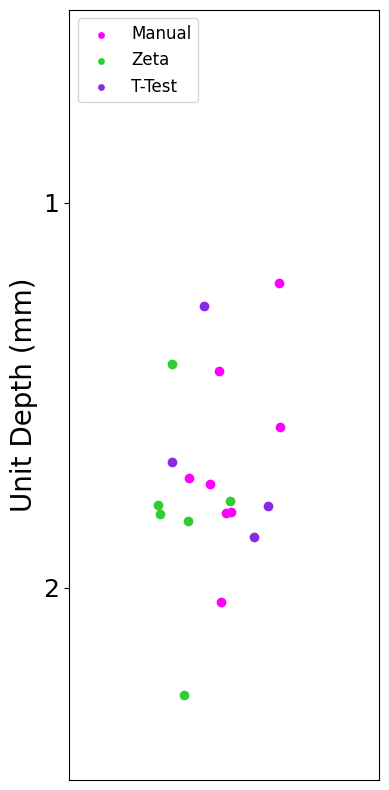

In [12]:
depthDict = pop.getUnitDepth(h5file, optoUnitsManual, optoUnitsZeta, optoUnitsT, depthDict=None)
fig, ax = pl.plotUnitDepth(depthDict, saveFig=False)
ax.scatter(0, 0, s=15, color='magenta', label='Manual')
ax.scatter(0, 0, s=15, color='limegreen', label='Zeta')
ax.scatter(0, 0, s=15, color='blueviolet', label='T-Test')
ax.set_ylim(250, 50)
ax.legend(fontsize=12, loc='upper left')

NameError: name 'fig' is not defined

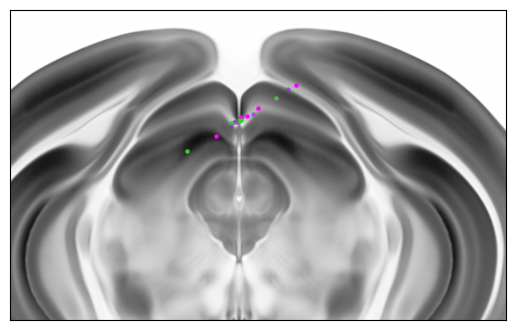

In [21]:
coordDict = pop.getUnitCoords(h5file, optoUnitsManual, optoUnitsZeta, optoUnitsT)
fig, ax = pl.plotUnitDepthOverBrain(coordDict)

In [27]:
optoUnits2 = list()
for unit in optoUnitsManual:
    if unit in optoUnitsZeta:
        optoUnits2.append(unit)
    if unit in optoUnitsT:
        optoUnits2.append(unit)
for unit in optoUnitsZeta:
    if unit in optoUnitsManual:
        optoUnits2.append(unit)
    if unit in optoUnitsT:
        optoUnits2.append(unit)
for unit in optoUnitsT:
    if unit in optoUnitsZeta:
        optoUnits2.append(unit)
    if unit in optoUnitsManual:
        optoUnits2.append(unit)
optoUnitsFinal = np.unique(optoUnits2)
print(optoUnitsFinal)

[ 99 146 173 181 382]


In [77]:
factory = SessionFactory(tag='Suguru')
#sessions = factory.produce(experiment=('NPDreadd'), animals=('dreadd4.2'))
sessions = factory.produce(experiment=('Muscimol'), animals=('dreadd1', 'dreadd2', 'dreadd3', 'dreadd4'))

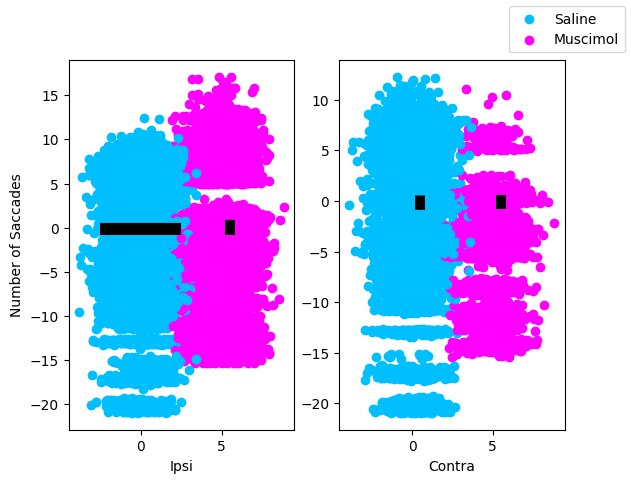

In [95]:
ipsiSal = list()
contraSal = list()
ipsiMus = list()
contraMus = list()
fig, ax = plt.subplots(1,2)
for session in sessions:
    h5file = os.path.join(session.home, 'output.hdf')
    labels = session.load('saccades/predicted/left/labels')
    #saccadesIpsi = len(np.where(labels == 1)[0])
    #saccadesContra = len(np.where(labels == -1)[0])
    saccadesIpsi = fs.calculateSaccadeStartPoint(h5file, session.saccadeTimestamps[labels==1, 0])
    saccadesContra = fs.calculateSaccadeStartPoint(h5file, session.saccadeTimestamps[labels==-1, 0])    
    if session.treatment == 'saline':
        ax[1].scatter(0 + np.random.randn(len(saccadesContra)), saccadesContra, color='deepskyblue', alpha=1)
        ax[0].scatter(0 + np.random.randn(len(saccadesIpsi)), saccadesIpsi, color='deepskyblue', alpha=1)
        ipsiSal.append(saccadesIpsi)
        contraSal.append(saccadesContra)
    elif session.treatment == 'muscimol':
        ax[1].scatter(5 + np.random.randn(len(saccadesContra)), saccadesContra, color='magenta', alpha=1)
        ax[0].scatter(5 + np.random.randn(len(saccadesIpsi)), saccadesIpsi, color='magenta', alpha=1)
        ipsiMus.append(saccadesIpsi)
        contraMus.append(saccadesContra)
avgIS = np.nanmean(ipsiSal)
avgCS = np.nanmean(contraSal)
avgIM = np.nanmean(ipsiMus)
avgCM = np.nanmean(contraMus)
ax[0].scatter(0, 0, color='deepskyblue', label='Saline')
ax[0].scatter(0, 0, color='magenta', label='Muscimol')
ax[0].hlines(avgIS, -2.5, 2.5, color='k')
ax[0].hlines(avgIM, 5.2, 5.8, color='k')
ax[1].hlines(avgCS, 0.2, 0.8, color='k')
ax[1].hlines(avgCM, 5.2, 5.8, color='k')
ax[0].set_xlabel('Ipsi')
ax[1].set_xlabel('Contra')
ax[0].set_ylabel('Number of Saccades')
#ax[0].set_xticks([])
#ax[1].set_xticks([])
#ax[0].set_ylim(0, 1000)
#ax[1].set_ylim(0, 1000)
fig.legend()

In [ ]:
#plot animal by animal or maybe lines for averages per animal